# Financial Time Series
# Asset correlations

In [66]:
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.special import kv
from scipy.stats import pearsonr
import itertools

In [2]:
returns = pd.read_csv('../data/log_returns.csv')
returns.tail()

,Date,Close_ACS.MC,Close_ACX.MC,Close_AENA.MC,Close_AMS.MC,Close_ANA.MC,Close_BBVA.MC,Close_BKT.MC,Close_CABK.MC,Close_CLNX.MC,...,Close_MTS.MC,Close_NTGY.MC,Close_RED.MC,Close_REP.MC,Close_ROVI.MC,Close_SAB.MC,Close_SAN.MC,Close_SCYR.MC,Close_SLR.MC,Close_TEF.MC
2599,2025-07-07,0.001768,0.011300,0.007520,0.009063,-0.011243,0.018032,0.012812,0.014256,-0.014236,...,0.016373,-0.009493,-0.001690,-0.002015,-0.022493,0.021024,0.023566,0.003386,-0.029128,-0.001758
2600,2025-07-08,-0.004427,0.019472,0.008120,-0.003389,-0.012526,0.016218,0.001316,-0.003940,-0.014442,...,0.013264,0.002930,-0.005086,0.035272,0.002726,0.014559,0.010359,-0.003951,-0.012392,-0.011057
2601,2025-07-09,0.006192,0.007319,0.024186,0.007609,0.017607,0.017430,0.017815,0.022894,0.001237,...,0.017300,-0.000732,0.001133,-0.004684,0.003623,0.023913,0.023452,0.014041,0.039125,0.004659
2602,2025-07-10,-0.010638,0.013581,-0.005992,0.012554,-0.003886,-0.018553,-0.009955,-0.027642,-0.001547,...,0.035079,-0.008085,-0.013102,0.002735,0.012579,-0.013215,-0.028073,-0.003352,-0.022309,-0.006217
2603,2025-07-11,0.006220,-0.000900,0.003642,-0.005560,0.003239,-0.031580,-0.014017,-0.011970,-0.001549,...,-0.006442,0.000738,-0.000574,0.013563,-0.005371,-0.026623,-0.017729,-0.004487,-0.005409,-0.002230


In [3]:
fit_results = pd.read_csv('../data/returns_fit.csv')
fit_results.head()

,Asset,loc,scale,se_loc,se_scale,p_value,ks_stat
0,SAB.MC,0.000537,0.018248,0.000385,0.000374,0.844981,0.011972
1,BBVA.MC,0.000777,0.014779,0.000394,0.000308,0.583355,0.015147
2,IAG.MC,0.000296,0.019202,0.000443,0.000417,0.422130,0.017165
3,REP.MC,0.000292,0.013568,0.000334,0.000280,0.360174,0.018048
4,MTS.MC,0.000000,0.020146,0.000459,0.000358,0.347118,0.018246


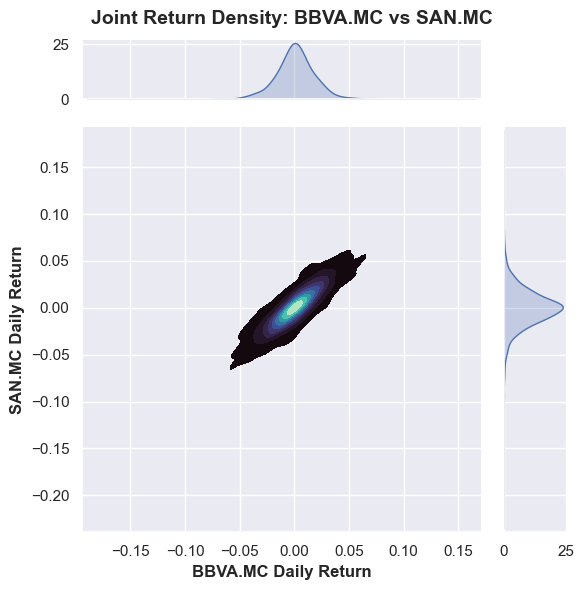

In [63]:
def Asset_Corr(asset1, asset2):
    sns.set(style="darkgrid")
    
    col1 = f"Close_{asset1}"
    col2 = f"Close_{asset2}"
    
    if col1 not in returns.columns or col2 not in returns.columns:
        raise ValueError("One or both asset columns not found in returns DataFrame.")
    
    g = sns.jointplot(
        data=returns, x=col1, y=col2,
        kind="kde", fill=True, cmap="mako",
        height=6, ratio=5, marginal_ticks=True
    )
    
    g.ax_joint.set_xlabel(f"{asset1} Daily Return", fontsize=12, fontweight='bold')
    g.ax_joint.set_ylabel(f"{asset2} Daily Return", fontsize=12, fontweight='bold')


    plt.suptitle(f"Joint Return Density: {asset1} vs {asset2}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93) 

    plt.show()

Asset_Corr("BBVA.MC", "SAN.MC")

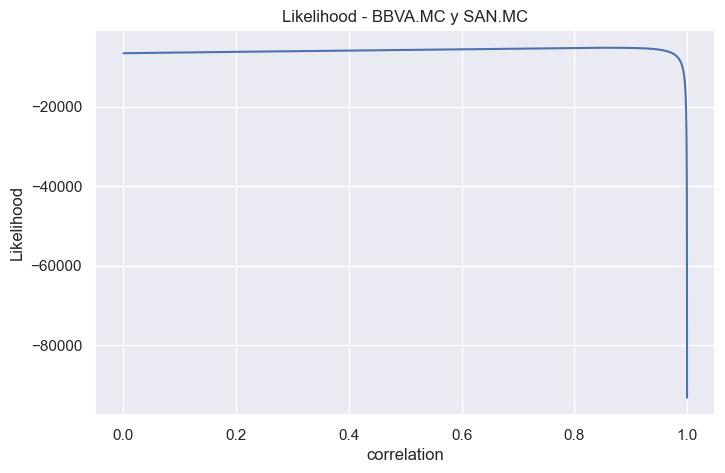

In [60]:
def Likelihood(data, asset1, asset2, results):
    corr = np.linspace(0, 0.9999, 10001)
    Likl = np.zeros(len(corr))
    
    fit1 = results[results['Asset'] == asset1].iloc[0]
    loc1 = fit1['loc']
    scale1 = fit1['scale']
    pred_vol1 = np.sqrt(2) * scale1 
    
    fit2 = results[results['Asset'] == asset2].iloc[0]
    loc2 = fit2['loc']
    scale2 = fit2['scale']
    pred_vol2 = np.sqrt(2) * scale2

    asset1_returns = (data[f"Close_{asset1}"] - loc1) / pred_vol1
    asset2_returns = (data[f"Close_{asset2}"] - loc2) / pred_vol2
    
    for i, c in enumerate(corr):
        z = np.sqrt(2 * (asset1_returns**2 + asset2_returns**2 - 
                         2 * c * asset1_returns * asset2_returns) / (1 - c**2))
        
        with np.errstate(divide='ignore', invalid='ignore'):
            log_bessel = np.log(kv(0, z))
        
        log_bessel = np.where(np.isfinite(log_bessel), log_bessel, -1e10)
        
        Likl[i] = np.sum(-np.log(np.pi) - 0.5 * np.log(1 - c**2) + log_bessel)
    
    return -Likl

def Plot_Likelihood(data, asset1, asset2, results):
    Likl = -Likelihood(data, asset1, asset2, results)
    corr = np.linspace(0, 0.9999, len(Likl))
    
    plt.figure(figsize=(8,5))
    plt.plot(corr, Likl)
    plt.xlabel('correlation')
    plt.ylabel('Likelihood')
    plt.title(f'Likelihood - {asset1} y {asset2}')
    plt.grid(True)
    plt.show()

Plot_Likelihood(returns, "BBVA.MC", "SAN.MC", fit_results)

In [68]:
def Maximum_Likelihood_Correlation_Estimation(data, asset1, asset2, results):
    neg_log_lik = Likelihood(data, asset1, asset2, results)
    corr = np.linspace(0, 0.9999, len(neg_log_lik))
    min_idx = np.argmin(neg_log_lik)

    corr_est = corr[min_idx]
    
    return corr_est



def Pearson_coef(data, asset1, asset2, results):
    fit1 = results[results['Asset'] == asset1].iloc[0]
    loc1 = fit1['loc']
    scale1 = fit1['scale']
    pred_vol1 = np.sqrt(2) * scale1 

    fit2 = results[results['Asset'] == asset2].iloc[0]
    loc2 = fit2['loc']
    scale2 = fit2['scale']
    pred_vol2 = np.sqrt(2) * scale2

    asset1_returns = (data[f"Close_{asset1}"] - loc1) / pred_vol1
    asset2_returns = (data[f"Close_{asset2}"] - loc2) / pred_vol2

    pearson_corr, _ = pearsonr(asset1_returns, asset2_returns)

    return pearson_corr

corr_est =Maximum_Likelihood_Correlation_Estimation(returns,  "GRF.MC", "TEF.MC",  fit_results)
print(f"Maximum Likelihood estimator: {corr_est:.4f}")
pearson_corr = Pearson_coef(returns,  "GRF.MC", "TEF.MC",  fit_results)
print(f"Pearson correlation coefficient: {pearson_corr:.4f}")

Maximum Likelihood estimator: 0.2379
Pearson correlation coefficient: 0.2252


In [ ]:
correlation_df = pd.DataFrame(columns=['Asset1', 'Asset2', 'ML_Correlation', 'Pearson_Correlation'])
assets = fit_results['Asset'].unique()

for asset1, asset2 in itertools.combinations(assets, 2):
    try:
        ml_corr = Maximum_Likelihood_Correlation_Estimation(returns,  asset1, asset2,  fit_results)
        pearson_corr = Pearson_coef(returns,  asset1, asset2,  fit_results)
    
        correlation_df = pd.concat([
            correlation_df,
            pd.DataFrame([{
                'Asset1': asset1,
                'Asset2': asset2,
                'ML_Correlation': ml_corr,
                'Pearson_Correlation': pearson_corr
            }])
        ], ignore_index=True)
    
    except Exception as e:
        print(f"Error processing pair ({asset1}, {asset2}): {e}")

correlation_df.to_csv("../data/correlations.csv", index=False)

C:\Users\juanc\AppData\Local\Temp\ipykernel_37524\3092703319.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_df = pd.concat([
